# Triplet Loss
해당 loss의 유효성을 확인하기 위한 실험으로, 코드가 지저분합니다^^*


참고) https://github.com/andreasveit/triplet-network-pytorch

### 설계
- 두 방향의 triplet loss를 고려하고 있다.
    1. 같은 폰트를 구분하는가
    2. 같은 글자를 구분하는가 <br/>
    
    
2번의 경우 데이터가 많이 부족하다. (같은 글자는 전체 데이터셋에서 107개 뿐) <br/>
그러나 MNIST와 유사한 형태이기 때문에 데이터 수만 확보된다면 가능할 것 같긴 하다.


1번의 경우 각 폰트마다 2350개의 글자가 있기 때문에 이 방향으로 구현할 것이다.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import shutil
import os

class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

## TrainLoader 커스텀
MNIST DataLoader를 커스텀하여 사용하기로 한다. <br/>
https://github.com/andreasveit/triplet-network-pytorch/blob/master/triplet_image_loader.py

In [ ]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset): 
    def __init__(self, pickled, triplets_file_name, base_path=None, filenames_filename=None, transform=None,
                 loader=default_image_loader):
        """ 
        filenames_filename: 
            A text file with each line containing the path to an image e.g.,
            images/class1/sample.jpg
                
        triplets_file_name: 
            A text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file. 
            For a line of intergers 'a b c', a triplet is defined such that image a is more 
            similar to image c than it is to image b, 
            e.g., 0 2017 42 
        """
        self.dset = pickled.examples
#         self.base_path = base_path  
#         self.filenamelist = []
#         for line in open(filenames_filename):
#             self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, far, close
        self.triplets = triplets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        img1_tuple = self.dset[int(path1)]
        img2_tuple = self.dset[int(path2)]
        img3_tuple = self.dset[int(path3)]
        
        # byte만 사용할 예정
        img1, byte_1 = img1_tuple[0], img1_tuple[1]
        img2, byte_2 = img2_tuple[0], img2_tuple[1]
        img3, byte_3 = img3_tuple[0], img3_tuple[1]
        
        # bytes 타입을 numpy array로 변경 후 normalize
        img_arr_1 = np.array(Image.open(io.BytesIO(byte_1)))
        img_arr_1 = normalize_image(img_arr_1)
        
        img_arr_2 = np.array(Image.open(io.BytesIO(byte_2)))
        img_arr_2 = normalize_image(img_arr_2)
        
        img_arr_3 = np.array(Image.open(io.BytesIO(byte_3)))
        img_arr_3 = normalize_image(img_arr_3)

        cropped_image_1, cropped_image_size_1 = tight_crop_image(img_arr_1, verbose=False)
        centered_image_1 = add_padding(cropped_image_1, verbose=False)
        
        cropped_image_2, cropped_image_size_2 = tight_crop_image(img_arr_2, verbose=False)
        centered_image_2 = add_padding(cropped_image_2, verbose=False)
        
        cropped_image_3, cropped_image_size_3 = tight_crop_image(img_arr_3, verbose=False)
        centered_image_3 = add_padding(cropped_image_3, verbose=False)
            
        return centered_image_1, centered_image_2, centered_image_3

    def __len__(self):
        return len(self.triplets)

In [ ]:
from common.utils import pad_seq, bytes_to_file, \
    read_split_image, shift_and_resize_image, normalize_image, \
    tight_crop_image, add_padding

from common.dataset import PickledImageProvider
from common.dataset import KoreanFontDataset

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader_all = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_all.txt')

processed 10000 examples
processed 20000 examples
processed 30000 examples
processed 40000 examples
processed 50000 examples
processed 60000 examples
processed 70000 examples
processed 80000 examples
processed 90000 examples
processed 100000 examples
processed 110000 examples
processed 120000 examples
processed 130000 examples
processed 140000 examples
processed 150000 examples
processed 160000 examples
processed 170000 examples
processed 180000 examples
processed 190000 examples
processed 200000 examples
processed 210000 examples
processed 220000 examples
processed 230000 examples
processed 240000 examples
processed 250000 examples
processed 260000 examples
processed 270000 examples
processed 280000 examples
processed 290000 examples
processed 300000 examples
processed 310000 examples
processed 320000 examples
processed 330000 examples
processed 340000 examples
processed 350000 examples
processed 360000 examples
processed 370000 examples
processed 380000 examples
processed 390000 exam

In [35]:
len(triplet_loader_all)

251450

---
# Triplet loss with Convolutional AutoEncoder
https://github.com/andreasveit/triplet-network-pytorch/blob/master/train.py

### Layers & Model

In [ ]:
# FontStyler의 convAE 코드 (layers.py)
class Encoder_conv(nn.Module):
    
    def __init__(self, img_dim=1, conv_dim=16): # output dim은 128이 될 것
        super(Encoder_conv, self).__init__()
        self.conv1 = conv2d(img_dim, conv_dim, k_size=5, stride=2, pad=2, dilation=2, lrelu=False, bn=False)
        self.conv2 = conv2d(conv_dim, conv_dim*2, k_size=5, stride=4, pad=2, dilation=2)
        self.conv3 = conv2d(conv_dim*2, conv_dim*4, k_size=4, stride=4, pad=1, dilation=1)
        self.conv4 = conv2d(conv_dim*4, conv_dim*8)
        self.conv5 = conv2d(conv_dim*8, conv_dim*8)
    
    def forward(self, images):
        # |images| = (batch, img, img)
        # print(images.shape)
        images = images.unsqueeze(dim=1)
        # |images| = (batch, 1, 128, 128)
        # print(images.shape)
        e1 = self.conv1(images)
        # |e1| = (batch, conv_dim, 64, 64)
        # print(e1.shape)
        e2 = self.conv2(e1)
        # |e2| = (batch, conv_dim*2, 16, 16)
        # print(e2.shape)
        e3 = self.conv3(e2)
        # |e3| = (batch, conv_dim*4, 4, 4)
        # print(e3.shape)
        e4 = self.conv4(e3)
        # |e4| = (batch, conv_dim*8, 2, 2)
        # print(e4.shape)
        encoded_source = self.conv5(e4)
        # |encoded_source| = (batch, conv_dim*8, 1, 1)
        # print(encoded_source.shape)
        
        return encoded_source
    
    
# class Decoder_conv(nn.Module):
    
#     def __init__(self, img_dim=1, embedded_dim=640, conv_dim=64):
#         super(Decoder_conv, self).__init__()
#         self.deconv1 = deconv2d(conv_dim*8, conv_dim*8, k_size=4, dilation=2, stride=2)
#         self.deconv2 = deconv2d(conv_dim*8, conv_dim*4, k_size=4, dilation=2, stride=2)
#         self.deconv3 = deconv2d(conv_dim*4, conv_dim*2, k_size=6, dilation=2, stride=4)
#         self.deconv4 = deconv2d(conv_dim*2, conv_dim*1, k_size=6, dilation=2, stride=4)
#         self.deconv5 = deconv2d(conv_dim*1, img_dim, k_size=4, dilation=2, stride=2, bn=False)
    
#     def forward(self, embedded):
#         # |embedded| = (batch, conv_dim*8, 1, 1)
#         d1 = self.deconv1(embedded)
#         # |d1| = (batch, conv_dim*8, 2, 2)
#         # print( 1.shape)
#         d2 = self.deconv2(d1)
#         # |d2| = (batch, conv_dim*4, 4, 4)
#         # print(d2.s hape)
#         d3 = self.deconv3(d2)
#         # |d3| = (batch, conv_dim*2, 16, 16)
#         # print(d3. shape)
#         d4 = self.deconv4(d3)
#         # |d4| = (batch, conv_dim*1, 64, 64)
#         # print(d4 .shape)
#         d5 = self.deconv5(d4)        
#         # |d5| = (batch, 1, 128, 128)
#         # print(d5. shape)
#         fake_target = d5
#         # |fake_target| = (batch_size, 1, img, img)
#         fake_target = fake_target.squeeze(dim=1)
#         # |fake_target| = (batch_size, img, img)
        
#         return fake_target
    
# class AE_conv(nn.Module):
#     def __init__(self, img_dim=1, conv_dim=64):
#         super(AE_conv, self).__init__()
#         self.Encoder = Encoder_conv(img_dim=img_dim, conv_dim=conv_dim)
#         self.Decoder = Decoder_conv(img_dim=img_dim, embedded_dim=conv_dim*8, conv_dim=conv_dim)
    
#     def forward(self, x):
#         z = self.Encoder(x)
#         x_hat = self.Decoder(z)
        
#         return x_hat, z

In [ ]:
# function.py
import torch.nn as nn

def batch_norm(c_out, momentum=0.1):
    return nn.BatchNorm2d(c_out, momentum=momentum)

def conv2d(c_in, c_out, k_size=3, stride=2, pad=1, dilation=1, bn=True, lrelu=True, leak=0.2):
    layers = []
    if lrelu:
        layers.append(nn.LeakyReLU(leak))
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def deconv2d(c_in, c_out, k_size=3, stride=1, pad=1, dilation=1, bn=True, dropout=False, p=0.5):
    layers = []
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

def lrelu(leak=0.2):
    return nn.LeakyReLU(leak)

def dropout(p=0.2):
    return nn.Dropout(p)

### Train Process
우선 latent.obj로 만든 triplet 데이터셋을 split한다. <br/>
train / val / test = 202100 / 37600 / 11750

In [38]:
len(triplet_loader_all)

251450

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_train = 202100
num_val = 37600
num_test = 11750

idxs = list(range(len(triplet_loader_all)))
np.random.shuffle(idxs)

In [ ]:
train_idxs, val_idxs, test_idxs = \
    idxs[:num_train], idxs[num_train: num_train+num_val], idxs[num_train+num_val: ]

In [42]:
len(train_idxs), len(val_idxs), len(test_idxs)

(202100, 37600, 11750)

In [ ]:
train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(val_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### default learning rate가 너무 큰 것 같아 조절을 해 보기로 했다.

In [ ]:
# hyperparameters
batch_size = 32 # 8
validation_split = .15
test_split = .05
shuffle_dataset = True
random_seed = 42
lr = 0.005 # 0.01
momentum = 0.5

best_acc = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
device

'cuda'

In [ ]:
train_loader = torch.utils.data.DataLoader(
        triplet_loader_all,
        batch_size = batch_size,
        sampler = train_sampler
    )

val_loader = torch.utils.data.DataLoader(
        triplet_loader_all,
        batch_size = batch_size,
        sampler = valid_sampler
    )

test_loader = torch.utils.data.DataLoader(
        triplet_loader_all,
        batch_size = batch_size,
        sampler = test_sampler
    )

In [ ]:
model = Encoder_conv()
tnet  = Tripletnet(model)

In [ ]:
criterion = torch.nn.MarginRankingLoss(margin = 0.2)
optimizer = optim.SGD(tnet.parameters(), lr=lr, momentum=momentum)

In [ ]:
def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    tnet = tnet.float()

    for batch_idx, (data1, data2, data3) in enumerate(train_loader):
        if device == 'cuda': #if args.cuda:                                     ## todo: args 말고 일반 cuda 변수로 바꾸기
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = data1.float(), data2.float(), data3.float()
        # compute output
        dista, distb, embedded_x, embedded_y, embedded_z = tnet(data1, data2, data3)
        # 1 means, dista should be larger than distb
        target = torch.FloatTensor(dista.size()).fill_(1)
        if device == 'cuda': #if args.cuda:                                     ## todo: args 말고 일반 cuda 변수로 바꾸기
            target = target.cuda()
        
        loss_triplet = criterion(dista, distb, target)
        loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        loss = loss_triplet + 0.001 * loss_embedd

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        losses.update(loss_triplet.item(), data1.size(0)) # .data[0]
        accs.update(acc, data1.size(0))
        emb_norms.update(loss_embedd.item()/3, data1.size(0)) # .data[0]

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))
    # log avg values to somewhere
    # visdom은 GCP에서 하자!!!!!!!!!!!
    # plotter.plot('acc', 'train', epoch, accs.avg)
    # plotter.plot('loss', 'train', epoch, losses.avg)
    # plotter.plot('emb_norms', 'train', epoch, emb_norms.avg)
    return losses.avg

def test(test_loader, tnet, criterion, epoch):
    losses = AverageMeter()
    accs = AverageMeter()

    # switch to evaluation mode
    tnet.eval()
    with torch.no_grad():
        for batch_idx, (data1, data2, data3) in enumerate(test_loader):
            if device == 'cuda': # if args.cuda:                                    ## todo: args 말고 일반 cuda 변수로 바꾸기
                data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
            data1, data2, data3 = data1.float(), data2.float(), data3.float()

            # compute output
            dista, distb, _, _, _ = tnet(data1, data2, data3)
            target = torch.FloatTensor(dista.size()).fill_(1)
            if device == 'cuda': #if args.cuda:                     ## todo: args 말고 일반 cuda 변수로 바꾸기
                target = target.cuda()
            test_loss =  criterion(dista, distb, target).item() #.data[0]

            # measure accuracy and record loss
            acc = accuracy(dista, distb)
            accs.update(acc, data1.size(0))
            losses.update(test_loss, data1.size(0))      

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
        losses.avg, 100. * accs.avg))
    # plotter.plot('acc', 'test', epoch, accs.avg)
    # plotter.plot('loss', 'test', epoch, losses.avg)
    return accs.avg, losses.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/runs/%s/"%('TripleNet')
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/runs/%s/'%('TripleNet') + 'model_best.pth.tar')

# class VisdomLinePlotter(object):
#     """Plots to Visdom"""
#     def __init__(self, env_name='main'):
#         self.viz = Visdom()
#         self.env = env_name
#         self.plots = {}
#     def plot(self, var_name, split_name, x, y):
#         if var_name not in self.plots:
#             self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
#                 legend=[split_name],
#                 title=var_name,
#                 xlabel='Epochs',
#                 ylabel=var_name
#             ))
#         else:
#             self.viz.updateTrace(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb - margin).cpu().data
    return (pred > 0).sum()*1.0/dista.size()[0]


In [ ]:
import io

# global plotter 
# plotter = VisdomLinePlotter(env_name='Triplet')

In [ ]:
# train process
if device == 'cuda':
    tnet.cuda()

In [54]:
train_history = []
val_history = []
for epoch in range(1, 10+1):
    print('=============== TRAIN epoch {} ==============='.format(epoch))
    # train for one epoch
    train_loss_avg = train(train_loader, tnet, criterion, optimizer, epoch)
    train_history.append(train_loss_avg)

    print('=============== TEST epoch {} ==============='.format(epoch))
    # evaluate on validation set
    acc, val_loss_avg = test(val_loader, tnet, criterion, epoch) # val
    val_history.append(val_loss_avg)

    print('=============== checkpoint epoch {} ==============='.format(epoch))
    # remember best acc and save checkpoint
    is_best = acc > best_acc
    best_acc = max(acc, best_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': tnet.state_dict(),
        'best_prec1': best_acc,
    }, is_best)

=============== TRAIN epoch 1 ===============
Train Epoch: 1 [0/251450]	Loss: 0.8623 (0.8623) 	Acc: 43.75% (43.75%) 	Emb_Norm: 63.99 (63.99)
Train Epoch: 1 [640/251450]	Loss: 0.5367 (0.8441) 	Acc: 62.50% (56.10%) 	Emb_Norm: 63.90 (63.95)
Train Epoch: 1 [1280/251450]	Loss: 0.3544 (0.7406) 	Acc: 75.00% (62.96%) 	Emb_Norm: 63.83 (63.91)
Train Epoch: 1 [1920/251450]	Loss: 0.5043 (0.7186) 	Acc: 65.62% (64.14%) 	Emb_Norm: 63.75 (63.87)
Train Epoch: 1 [2560/251450]	Loss: 0.2176 (0.6675) 	Acc: 75.00% (66.82%) 	Emb_Norm: 63.68 (63.83)
Train Epoch: 1 [3200/251450]	Loss: 0.1874 (0.6104) 	Acc: 87.50% (69.49%) 	Emb_Norm: 63.63 (63.79)
Train Epoch: 1 [3840/251450]	Loss: 0.3680 (0.5808) 	Acc: 81.25% (70.92%) 	Emb_Norm: 63.57 (63.76)
Train Epoch: 1 [4480/251450]	Loss: 0.3729 (0.5583) 	Acc: 87.50% (71.92%) 	Emb_Norm: 63.52 (63.73)
Train Epoch: 1 [5120/251450]	Loss: 0.7421 (0.5340) 	Acc: 78.12% (73.19%) 	Emb_Norm: 63.46 (63.70)
Train Epoch: 1 [5760/251450]	Loss: 0.2797 (0.5137) 	Acc: 84.38% (73.90%) 	Em

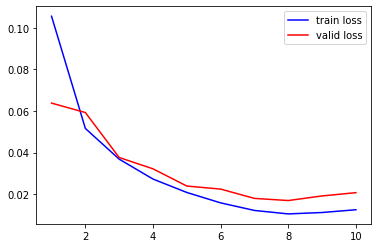

In [55]:
epochs = list(range(1,11))
fig, ax = plt.subplots()

plot_train = ax.plot(epochs, train_history, color='b', label='train loss')
plot_test  = ax.plot(epochs, val_history, color='r', label='valid loss')

plt.legend()
plt.show()

learning rate를 반으로 줄였더니 잘 출력된다.